In [1]:

import numpy as np
import pandas


import skimage.data
import skimage.transform
from skimage import data, io, filters

In [2]:
import math
import os

width = 320
height = 240
# Import Labels
labels = []
imagePaths = []
lastTrackingAngle = 0
lastSpeed = 0
for i in range(20,41):
    fname = "/home/matt/Desktop/RainierDrive/AccelerationData/capture"+str(i)+"/accelClass.txt"
    base = "/home/matt/Desktop/RainierDrive/AccelerationData/capture"+str(i) + "/"
    
    if(not os.path.isfile(fname)):
        print("Could not find file for capture ", str(i))
        continue
    with open(fname) as f:
        content = f.readlines()
        for line in content:
            line = line.split(",")
            speedString = (line[1].split(" "))[2]
            speed = float(speedString)
            trackingAngleString = (line[8].split(" "))[2]
            trackingAngle = float(trackingAngleString)
            deltaTrackingAngle = trackingAngle - lastTrackingAngle
            deltaSpeed = speed - lastSpeed
            lastTrackingAngle = trackingAngle
            lastSpeed = speed
            filePath = (line[10])
            if speed > 20 and abs(deltaTrackingAngle) > 2 and abs(deltaTrackingAngle) < 7:
                if(deltaTrackingAngle>0):
                    deltaTrackingAngle = 0
                else:
                    deltaTrackingAngle = 1
                angleArray = np.zeros(2)
                angleArray[deltaTrackingAngle] = 1
                labels.append(angleArray)
                #labels.append(deltaTrackingAngle)
                #print speed
                #print trackingAngle
                picturePath = base+filePath
                #print picturePath
                imagePaths.append(picturePath)

trainingIndex = int(len(imagePaths)/1.4)
print trainingIndex

('Could not find file for capture ', '27')
('Could not find file for capture ', '32')
('Could not find file for capture ', '33')
('Could not find file for capture ', '34')
('Could not find file for capture ', '35')
2224


In [3]:
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters

from skimage.color import rgb2gray
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters
import operator
from operator import sub


@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)

def as_gray(image_filter, image, *args, **kwargs):
    gray_image = rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

@adapt_rgb(as_gray)
def sobel_gray(image):
    return filters.sobel(image)



images = np.zeros((len(imagePaths),height,width))
print(images.shape)
threadCount = 20
import threading

def worker(loadPath, loadPath2, imageIndex):
    """thread worker function"""
    #image = skimage.data.imread(loadPath)
    image2 = skimage.data.imread(loadPath2)
    #image = skimage.transform.resize(image, (height, width), mode='reflect')
    image2 = skimage.transform.resize(image2, (height, width), mode='reflect')
    #edges = sobel_each(image)
    #edges2 = sobel_each(image2)
    #edges3 = edges2+edges
    image2 = rgb2gray(image2)
    images[imageIndex] = image2
    return imageIndex

for imNum in range(0,len(imagePaths),threadCount):
    threads = []
    for i in range(threadCount):
        
        if(imNum+i >= len(imagePaths)):
            continue
        if(imNum+1==0):
            loadPath = imagePaths[mNum+i]
            loadPath2 = imagePaths[imNum+i]
        else:
            loadPath = imagePaths[imNum+i-1]
            loadPath2 = imagePaths[imNum+i]
        t = threading.Thread(target=worker, args=(loadPath,loadPath2,imNum+i))
        threads.append(t)
        t.start()

(3114, 240, 320)


[[ 0.68767157  0.68921569  0.69215686 ...,  0.63431373  0.62941176
   0.62745098]
 [ 0.69117647  0.69215686  0.69313725 ...,  0.63235294  0.62941176
   0.62745098]
 [ 0.69734157  0.69607843  0.69411765 ...,  0.62843137  0.63039216
   0.62941176]
 ..., 
 [ 0.23959118  0.23233804  0.22884059 ...,  0.14689863  0.14789216
   0.15923275]
 [ 0.29578824  0.30361824  0.29662157 ...,  0.15391412  0.15489451
   0.15755863]
 [ 0.42429529  0.42361078  0.41479294 ...,  0.20784137  0.19788863
   0.18963451]]


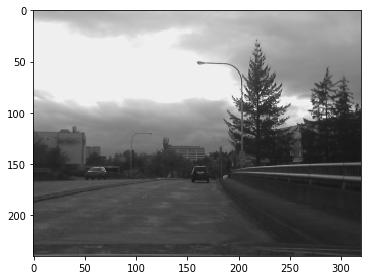

In [4]:

image = images[23]
print(images[23])
io.imshow(image)
io.show()

In [5]:

images = np.asarray(images)
images = images.reshape(len(images),1,width*height)

In [6]:
labels = np.array(labels)
images = np.array(images)
print("labels: ", labels.shape, "\nimages: ", images.shape)

('labels: ', (3114, 2), '\nimages: ', (3114, 1, 76800))


In [7]:
maxLength = trainingIndex
global currentPos
currentPos = 0
def next(batch_size):
    """ Return a batch of data. When dataset end is reached, start over.
    """
    #if self.batch_id == len(self.data):
    #    self.batch_id = 0
    #batch_data = (self.data[self.batch_id:min(self.batch_id +
    #                                          batch_size, len(self.data))])
    #batch_labels = (self.labels[self.batch_id:min(self.batch_id +
    #                                          batch_size, len(self.data))])
    #batch_seqlen = (self.seqlen[self.batch_id:min(self.batch_id +
    #                                          batch_size, len(self.data))])
    #self.batch_id = min(self.batch_id + batch_size, len(self.data))
    global currentPos
    currentPos = currentPos + batch_size
    maxPos = currentPos + batch_size
    if(maxPos>maxLength):
        currentPos = 0
        maxPos = currentPos + batch_size
    batch_data = (images[currentPos:maxPos])
    batch_labels = (labels[currentPos:maxPos])
    return batch_data, batch_labels



In [8]:
maxTestingLength = len(labels)
global currentTestingPos
global minIndex 
minIndex = trainingIndex
currentTestingPos = minIndex

def nextTesting(batch_size):
    global currentTestingPos
    global minIndex
    currentTestingPos = currentTestingPos + batch_size
    maxPos = currentTestingPos + batch_size
    if(maxPos>maxTestingLength):
        currentTestingPos = minIndex
        maxPos = currentTestingPos + batch_size
    batch_data = (images[currentTestingPos:maxPos])
    batch_labels = (labels[currentTestingPos:maxPos])
    return batch_data, batch_labels

In [9]:
x, y = next(128)
print(x.shape)
print(y)

x, y = nextTesting(128)
print(x.shape)
print(y)

cellInitialized = 0

(128, 1, 76800)
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.

In [10]:
'''
A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn

'''
To classify images using a recurrent neural network, we consider every image
row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then
handle 28 sequences of 28 steps for every sample.
'''

# Parameters
learning_rate = 0.0001
training_epochs = 15
batch_size = 64
display_step = 10

# Network Parameters
n_hidden_1 = 2500 # 1st layer number of features
n_hidden_2 = 2500 # 2nd layer number of features
n_input = width*height # MNIST data input (img shape: 28*28)
n_classes = 2 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])


# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))

# Calculate accuracy
modelaccuracy = tf.reduce_mean(tf.cast(correct_pred, "float"))


# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
sess=tf.Session()
sess.run(init)



In [15]:
training_iters = 900000
display_step = 10
step = 1
# Keep training until reach max iterations
while step * batch_size < training_iters:
    batch_x, batch_y = next(batch_size)
    # Reshape data to get 28 seq of 28 elements
    batch_x = batch_x.reshape((batch_size, n_input))
    batch_y = batch_y.reshape((batch_size, 2))
    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    if step % display_step == 0:
        # Calculate batch accuracy
        mc = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        acc = sess.run(modelaccuracy, feed_dict={x: batch_x, y: batch_y})
        print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(mc) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")


Iter 640, Minibatch Loss= 13526.873047, Training Accuracy= 0.67188
Iter 1280, Minibatch Loss= 27765.988281, Training Accuracy= 0.54688
Iter 1920, Minibatch Loss= 2208.250732, Training Accuracy= 0.93750
Iter 2560, Minibatch Loss= 21851.048828, Training Accuracy= 0.68750
Iter 3200, Minibatch Loss= 8917.289062, Training Accuracy= 0.78125
Iter 3840, Minibatch Loss= 5285.639648, Training Accuracy= 0.90625
Iter 4480, Minibatch Loss= 1407.609497, Training Accuracy= 0.90625
Iter 5120, Minibatch Loss= 2683.561035, Training Accuracy= 0.87500
Iter 5760, Minibatch Loss= 10758.496094, Training Accuracy= 0.75000
Iter 6400, Minibatch Loss= 4386.318359, Training Accuracy= 0.82812
Iter 7040, Minibatch Loss= 7032.962891, Training Accuracy= 0.70312
Iter 7680, Minibatch Loss= 6920.028809, Training Accuracy= 0.79688
Iter 8320, Minibatch Loss= 2705.153320, Training Accuracy= 0.90625
Iter 8960, Minibatch Loss= 3217.657715, Training Accuracy= 0.90625
Iter 9600, Minibatch Loss= 3069.705566, Training Accuracy= 

Iter 78080, Minibatch Loss= 1605.843140, Training Accuracy= 0.90625
Iter 78720, Minibatch Loss= 4635.584961, Training Accuracy= 0.81250
Iter 79360, Minibatch Loss= 5260.723633, Training Accuracy= 0.67188
Iter 80000, Minibatch Loss= 2550.522461, Training Accuracy= 0.93750
Iter 80640, Minibatch Loss= 608.537781, Training Accuracy= 0.95312
Iter 81280, Minibatch Loss= 3312.454102, Training Accuracy= 0.84375
Iter 81920, Minibatch Loss= 5133.302246, Training Accuracy= 0.79688
Iter 82560, Minibatch Loss= 3793.996582, Training Accuracy= 0.84375
Iter 83200, Minibatch Loss= 1143.747925, Training Accuracy= 0.81250
Iter 83840, Minibatch Loss= 3989.809082, Training Accuracy= 0.82812
Iter 84480, Minibatch Loss= 4925.585938, Training Accuracy= 0.79688
Iter 85120, Minibatch Loss= 1778.126221, Training Accuracy= 0.89062
Iter 85760, Minibatch Loss= 1079.826050, Training Accuracy= 0.93750
Iter 86400, Minibatch Loss= 2248.529053, Training Accuracy= 0.89062
Iter 87040, Minibatch Loss= 4506.841797, Training

Iter 155520, Minibatch Loss= 3315.467773, Training Accuracy= 0.81250
Iter 156160, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 156800, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 157440, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 158080, Minibatch Loss= 432.250000, Training Accuracy= 0.98438
Iter 158720, Minibatch Loss= 174.598755, Training Accuracy= 0.98438
Iter 159360, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 160000, Minibatch Loss= 274.125061, Training Accuracy= 0.96875
Iter 160640, Minibatch Loss= 1299.496338, Training Accuracy= 0.90625
Iter 161280, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 161920, Minibatch Loss= 545.860596, Training Accuracy= 0.92188
Iter 162560, Minibatch Loss= 154.693481, Training Accuracy= 0.96875
Iter 163200, Minibatch Loss= 374.320496, Training Accuracy= 0.96875
Iter 163840, Minibatch Loss= 3573.414307, Training Accuracy= 0.75000
Iter 164480, Minibatch Loss= 4772.521973, Training Accu

Iter 232960, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 233600, Minibatch Loss= 485.501343, Training Accuracy= 0.98438
Iter 234240, Minibatch Loss= 669.669434, Training Accuracy= 0.95312
Iter 234880, Minibatch Loss= 499.784058, Training Accuracy= 0.95312
Iter 235520, Minibatch Loss= 1375.352417, Training Accuracy= 0.90625
Iter 236160, Minibatch Loss= 313.146606, Training Accuracy= 0.98438
Iter 236800, Minibatch Loss= 318.533020, Training Accuracy= 0.93750
Iter 237440, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 238080, Minibatch Loss= 47.733154, Training Accuracy= 0.98438
Iter 238720, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 239360, Minibatch Loss= 446.811035, Training Accuracy= 0.95312
Iter 240000, Minibatch Loss= 3715.166016, Training Accuracy= 0.67188
Iter 240640, Minibatch Loss= 862.128357, Training Accuracy= 0.96875
Iter 241280, Minibatch Loss= 5.684082, Training Accuracy= 0.98438
Iter 241920, Minibatch Loss= 498.546967, Training Accur

KeyboardInterrupt: 

In [16]:
#Speed accuracy

step = 1
totalMAE = 0
correctDirectionCount = 0
totalCount = 0
threshold = 12
# Calculate accuracy for 128 mnist test images
while step * batch_size < (len(images)-trainingIndex):
    test_data, test_label = nextTesting(batch_size)
    test_data = test_data.reshape((batch_size, n_input))
    test_label = test_label.reshape((batch_size, 2))
    predAccuracy = sess.run(modelaccuracy, feed_dict={x: test_data, y: test_label})
    totalMAE = totalMAE + predAccuracy
    results = sess.run(pred, feed_dict={x: test_data})
    print("Testing Accuracy:", predAccuracy)
    print(str(totalMAE/(step)))
    step+=1


Testing Accuracy: 0.453125
0.453125
Testing Accuracy: 0.46875
0.4609375
Testing Accuracy: 0.46875
0.463541666667
Testing Accuracy: 0.46875
0.46484375
Testing Accuracy: 0.703125
0.5125
Testing Accuracy: 0.59375
0.526041666667
Testing Accuracy: 0.609375
0.537946428571
Testing Accuracy: 0.53125
0.537109375
Testing Accuracy: 0.609375
0.545138888889
Testing Accuracy: 0.625
0.553125
Testing Accuracy: 0.609375
0.558238636364
Testing Accuracy: 0.546875
0.557291666667
Testing Accuracy: 0.71875
0.569711538462
